In [43]:
from datetime import datetime, timedelta
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

In [44]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d %H:%M:%S')

In [45]:
df = pd.read_csv('train.csv', parse_dates=[0], index_col=0
                ,squeeze=True, date_parser=parser)
df.head()

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
date_time,,,,,,,,,,,
2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8


# Split into training and validation set

In [46]:
train_end = pd.to_datetime('2010-11-30 23:00:00',)

train = df[:train_end]
val = df[train_end + timedelta(hours=1):]

In [47]:
x_train = train.iloc[:, 0:8]

# Carbon monoxide

# Normalise

In [50]:
x_train_CO = x_train
y_train_CO = train.iloc[:, 8]

x_train_CO_mean, x_train_CO_sd = x_train_CO.mean(), x_train_CO.std()
y_train_CO_mean, y_train_CO_sd = y_train_CO.mean(), y_train_CO.std()

x_train_CO_norm = (x_train_CO-x_train_CO_mean)/x_train_CO_sd
y_train_CO_norm = (y_train_CO-y_train_CO_mean)/y_train_CO_sd

In [51]:
import statsmodels.api as sm
model = sm.OLS(y_train_CO_norm, x_train_CO_norm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     target_carbon_monoxide   R-squared (uncentered):                   0.881
Model:                                OLS   Adj. R-squared (uncentered):              0.881
Method:                     Least Squares   F-statistic:                              5885.
Date:                    Wed, 25 May 2022   Prob (F-statistic):                        0.00
Time:                            22:19:40   Log-Likelihood:                         -2256.5
No. Observations:                    6366   AIC:                                      4529.
Df Residuals:                        6358   BIC:                                      4583.
Df Model:                               8                                                  
Covariance Type:                nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
deg_C                 0.0787      0.012      6.375      0.000       0.054       0.103
relative_humidity     0.1147      0.012      9.533      0.000       0.091       0.138
absolute_humidity    -0.1077      0.012     -9.347      0.000      -0.130      -0.085
sensor_1              0.3138      0.010     32.745      0.000       0.295       0.333
sensor_2              0.7278      0.016     46.479      0.000       0.697       0.758
sensor_3              0.1968      0.011     18.713      0.000       0.176       0.217
sensor_4             -0.0273      0.010     -2.728      0.006      -0.047      -0.008
sensor_5              0.1219      0.011     10.992      0.000       0.100       0.144
==============================================================================
Omnibus:                     1902.732   Durbin-Watson:                   0.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24934.426
Skew:                           1.057   Prob(JB):                         0.00
Kurtosis:                      12.462   Cond. No.                         9.89
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Sensor 4 is not a significant independent variable

In [52]:
x_train_CO_norm = x_train_CO_norm.drop(columns=['sensor_4'])

# Fit multiple linear regression model

In [53]:
x_train_CO_norm = x_train_CO_norm.values
y_train_CO_norm = y_train_CO_norm.values

regressor_CO = LinearRegression()
regressor_CO.fit(x_train_CO_norm, y_train_CO_norm)

LinearRegression()

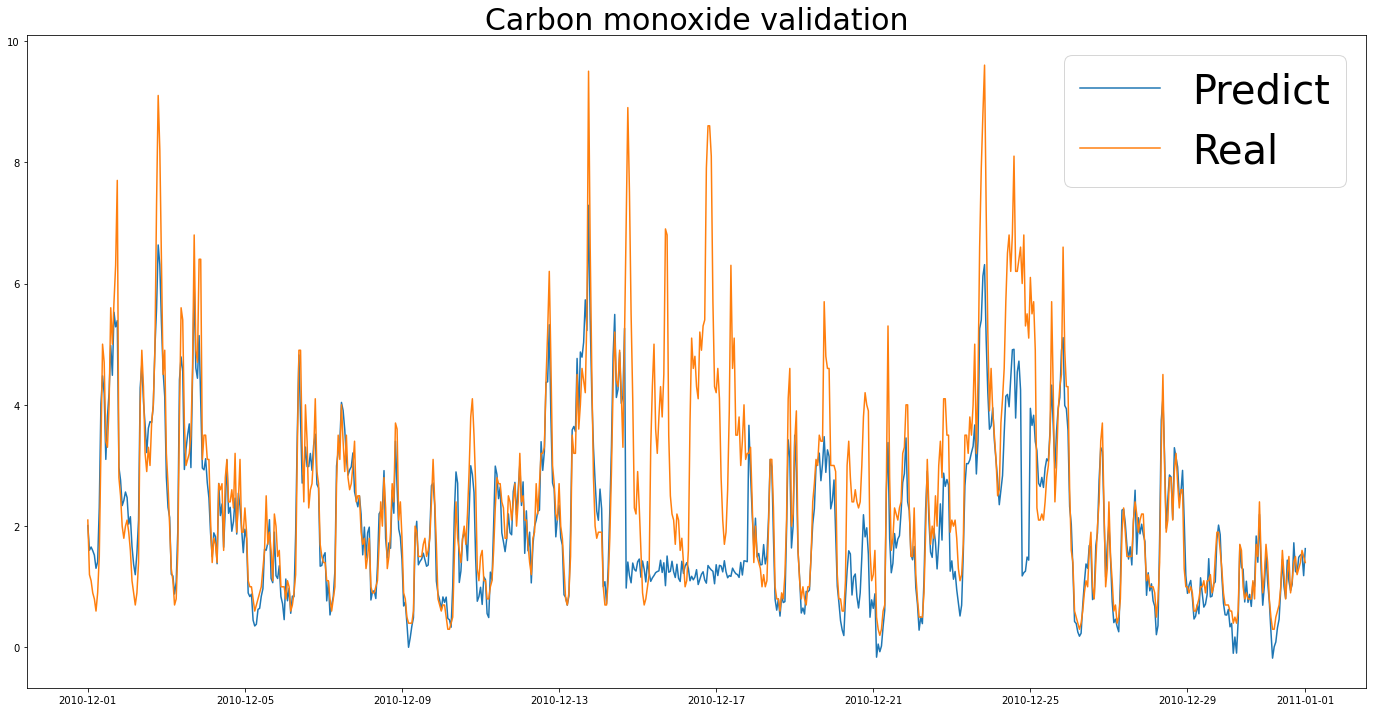

In [54]:
x_val_CO = val.iloc[:, np.r_[0:6,7:8]]
y_val_CO = val.iloc[:, 8]

x_val_CO_mean, x_val_CO_sd = x_val_CO.mean(), x_val_CO.std()

x_val_CO_norm = (x_val_CO-x_val_CO_mean)/x_val_CO_sd

x_val_CO_norm = x_val_CO_norm.values

x_pred_CO = regressor_CO.predict(x_val_CO_norm)


idx = val.index
x_pred_CO = pd.Series(x_pred_CO, index=idx)
x_pred_CO = x_pred_CO*y_train_CO_sd + y_train_CO_mean


plt.figure(figsize=(24,12))
plt.title('Carbon monoxide validation', fontsize=30)
plt.plot(x_pred_CO, label = 'Predict')
plt.plot(y_val_CO, label = 'Real')
plt.legend(prop={'size': 40})

# Residual

In [55]:
residual = x_pred_CO - y_val_CO
residual.mean() / y_val_CO.mean()

-0.19698476821335667

# 




# Benzene

# Normalise

In [56]:
x_train_ben = x_train
y_train_ben = train.iloc[:, 9]

x_train_ben_mean, x_train_ben_sd = x_train_ben.mean(), x_train_ben.std()
y_train_ben_mean, y_train_ben_sd = y_train_ben.mean(), y_train_ben.std()

x_train_ben_norm = (x_train_ben-x_train_ben_mean)/x_train_ben_sd
y_train_ben_norm = (y_train_ben-y_train_ben_mean)/y_train_ben_sd

In [57]:
model = sm.OLS(y_train_ben_norm, x_train_ben_norm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         target_benzene   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                          1.546e+04
Date:                Wed, 25 May 2022   Prob (F-statistic):                        0.00
Time:                        22:20:30   Log-Likelihood:                          573.41
No. Observations:                6366   AIC:                                     -1131.
Df Residuals:                    6358   BIC:                                     -1077.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
deg_C                 0.0307      0.008      3.879      0.000       0.015       0.046
relative_humidity     0.0275      0.008      3.572      0.000       0.012       0.043
absolute_humidity    -0.0055      0.007     -0.746      0.456      -0.020       0.009
sensor_1              0.0544      0.006      8.851      0.000       0.042       0.066
sensor_2              0.8861      0.010     88.268      0.000       0.866       0.906
sensor_3              0.1848      0.007     27.406      0.000       0.172       0.198
sensor_4              0.0602      0.006      9.394      0.000       0.048       0.073
sensor_5              0.1568      0.007     22.050      0.000       0.143       0.171
==============================================================================
Omnibus:                     1846.121   Durbin-Watson:                   1.258
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13306.134
Skew:                           1.194   Prob(JB):                         0.00
Kurtosis:                       9.668   Cond. No.                         9.89
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Absolute humidity is not a significant independent variable

In [58]:
x_train_ben_norm = x_train_ben_norm.drop(columns=['absolute_humidity'], axis=1)

# Fit multiple linear regression model

In [59]:
x_train_ben_norm = x_train_ben_norm.values
y_train_ben_norm = y_train_ben_norm.values

regressor_ben = LinearRegression()
regressor_ben.fit(x_train_ben_norm, y_train_ben_norm)

LinearRegression()

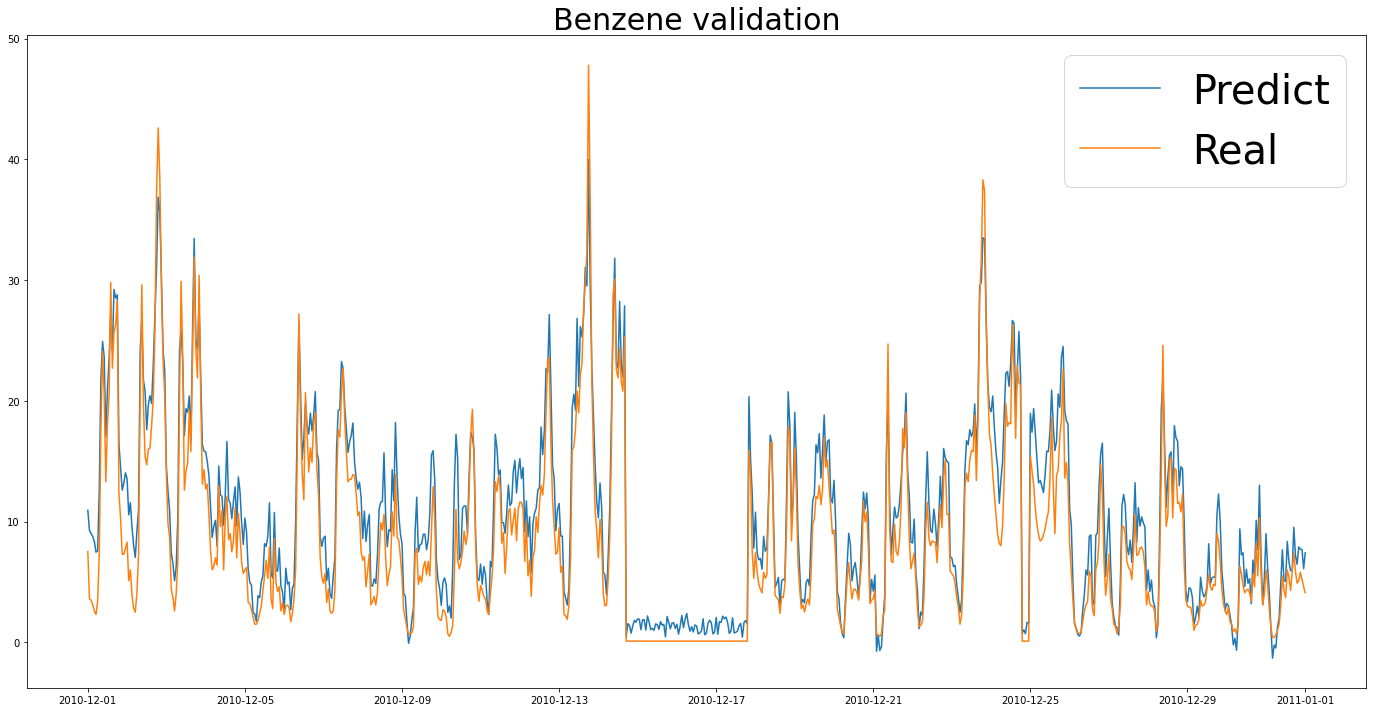

In [60]:
x_val_ben = val.iloc[:, np.r_[0:2,3:8]]
y_val_ben = val.iloc[:, 9]

x_val_ben_mean, x_val_ben_sd = x_val_ben.mean(), x_val_ben.std()

x_val_ben_norm = (x_val_ben-x_val_ben_mean)/x_val_ben_sd

x_val_ben_norm = x_val_ben_norm.values

x_pred_ben = regressor_ben.predict(x_val_ben_norm)


idx = val.index
x_pred_ben = pd.Series(x_pred_ben, index=idx)
x_pred_ben = x_pred_ben*y_train_ben_sd + y_train_ben_mean


plt.figure(figsize=(24,12))
plt.title('Benzene validation', fontsize=30)
plt.plot(x_pred_ben, label = 'Predict')
plt.plot(y_val_ben, label = 'Real')
plt.legend(prop={'size': 40})

# Residual

In [61]:
residual = x_pred_ben - y_val_ben
residual.mean() / y_val_ben.mean()

0.23739035233127126

# 




# Nitorgen oxides 

# normalise

In [62]:
x_train_no = x_train
y_train_no = train.iloc[:, 10]

x_train_no_mean, x_train_no_sd = x_train_no.mean(), x_train_no.std()
y_train_no_mean, y_train_no_sd = y_train_no.mean(), y_train_no.std()

x_train_no_norm = (x_train_no-x_train_no_mean)/x_train_no_sd
y_train_no_norm = (y_train_no-y_train_no_mean)/y_train_no_sd

In [63]:
model = sm.OLS(y_train_no_norm, x_train_no_norm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     target_nitrogen_oxides   R-squared (uncentered):                   0.739
Model:                                OLS   Adj. R-squared (uncentered):              0.738
Method:                     Least Squares   F-statistic:                              2245.
Date:                    Wed, 25 May 2022   Prob (F-statistic):                        0.00
Time:                            22:21:33   Log-Likelihood:                         -4762.2
No. Observations:                    6366   AIC:                                      9540.
Df Residuals:                        6358   BIC:                                      9594.
Df Model:                               8                                                  
Covariance Type:                nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
deg_C                -0.0148      0.018     -0.807      0.420      -0.051       0.021
relative_humidity     0.1960      0.018     10.994      0.000       0.161       0.231
absolute_humidity     0.0773      0.017      4.522      0.000       0.044       0.111
sensor_1              0.0683      0.014      4.808      0.000       0.040       0.096
sensor_2              0.9852      0.023     42.445      0.000       0.940       1.031
sensor_3              0.0148      0.016      0.952      0.341      -0.016       0.045
sensor_4             -0.7042      0.015    -47.556      0.000      -0.733      -0.675
sensor_5              0.3135      0.016     19.071      0.000       0.281       0.346
==============================================================================
Omnibus:                     2713.385   Durbin-Watson:                   0.664
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27714.986
Skew:                           1.761   Prob(JB):                         0.00
Kurtosis:                      12.596   Cond. No.                         9.89
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# temperature and sensor 3 are not significant independent variables

In [64]:
x_train_no_norm = x_train_no_norm.drop(columns=['sensor_3', 'deg_C'], axis=1)

# Fit multiple linear regression model

In [65]:
x_train_no_norm = x_train_no_norm.values
y_train_no_norm = y_train_no_norm.values

regressor = LinearRegression()
regressor.fit(x_train_no_norm, y_train_no_norm)

LinearRegression()

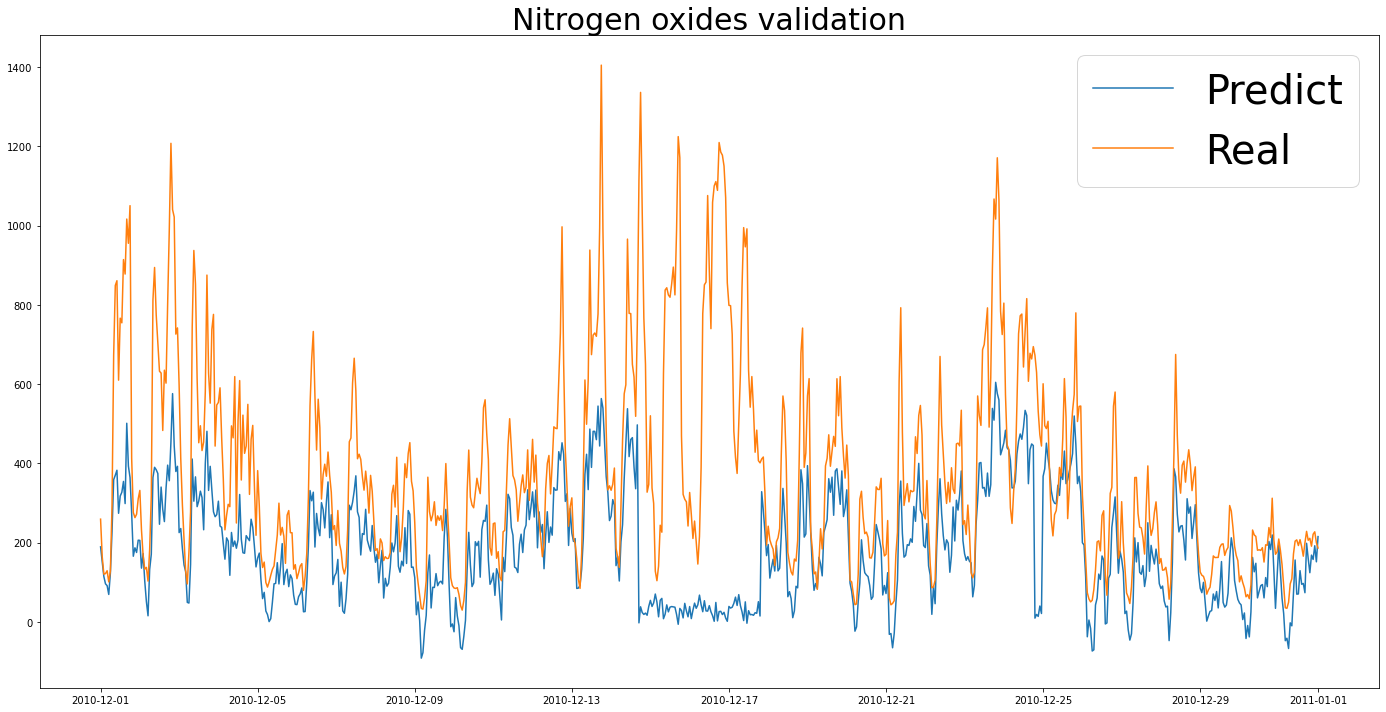

In [66]:
x_val_no = val.iloc[:, np.r_[1:5,6:8]]
y_val_no = val.iloc[:, 10]

x_val_no_mean, x_val_no_sd = x_val_no.mean(), x_val_no.std()

x_val_no_norm = (x_val_no-x_val_no_mean)/x_val_no_sd

x_val_no_norm = x_val_no_norm.values

x_pred_no = regressor.predict(x_val_no_norm)


idx = val.index
x_pred_no = pd.Series(x_pred_no, index=idx)
x_pred_no = x_pred_no*y_train_no_sd + y_train_no_mean


plt.figure(figsize=(24,12))
plt.title('Nitrogen oxides validation', fontsize=30)
plt.plot(x_pred_no, label = 'Predict')
plt.plot(y_val_no, label = 'Real')
plt.legend(prop={'size': 40})

# Residual

In [67]:
residual = x_pred_no - y_val_no
residual.mean() / y_val_no.mean()

-0.5181126220814399

# Significant amount of residual, experiment with polynomial regression model

In [68]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 4)
x_train_no_norm_poly = poly_reg.fit_transform(x_train_no_norm)

poly_model = LinearRegression()
poly_model.fit(x_train_no_norm_poly, y_train_no_norm)

print('training complete')

training complete


In [69]:
x_val_no_norm_poly = poly_reg.fit_transform(x_val_no_norm)
x_pred_poly_no = poly_model.predict(x_val_no_norm_poly)

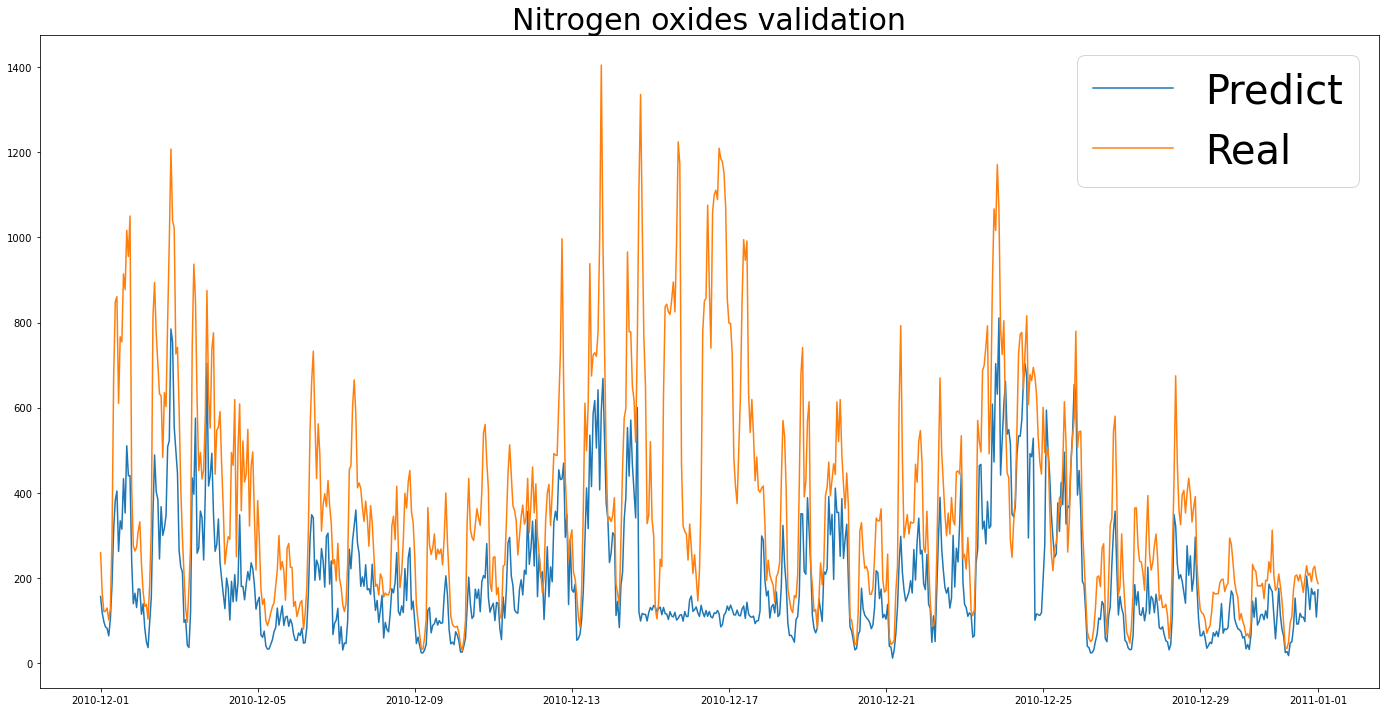

In [70]:

x_pred_poly_no = pd.Series(x_pred_poly_no, index = val.index)

x_pred_poly_no = x_pred_poly_no*y_train_no_sd + y_train_no_mean

plt.figure(figsize=(24,12))
plt.title('Nitrogen oxides validation', fontsize=30)
plt.plot(x_pred_poly_no, label = 'Predict')
plt.plot(y_val_no, label = 'Real')
plt.legend(prop={'size': 40})


In [71]:
residual_poly =  x_pred_poly_no - y_val_no
residual_poly.mean() / y_val_no.mean()

-0.48173652574179515

# Testing

In [30]:
test = pd.read_csv('test.csv', parse_dates=[0], index_col=0
                ,squeeze=True, date_parser=parser)

In [40]:
test_mean = test.mean()
test_sd = test.std()

test_norm = (test-test_mean) / test_sd

In [32]:
test_CO = test_norm.drop(columns=['sensor_4'])
test_ben = test_norm.drop(columns=['absolute_humidity'])
test_no = test_norm.drop(columns=['sensor_3', 'deg_C'])

In [33]:
# CO
CO_pred = regressor_CO.predict(test_CO)
CO_pred = CO_pred*y_train_CO_sd + y_train_CO_mean

In [34]:
# benzene

ben_pred = regressor_ben.predict(test_ben)
ben_pred = ben_pred*y_train_ben_sd + y_train_ben_mean

In [35]:
# NO

test_no = poly_reg.fit_transform(test_no)
no_pred = poly_model.predict(test_no)

no_pred = no_pred*y_train_no_sd + y_train_no_mean

In [39]:
test = pd.DataFrame({'target_carbon_monoxide': CO_pred, 
                     'target_benzene': ben_pred, 
                    'target_nitrogen_oxides': no_pred}, index = test.index)

test.to_csv('submission.csv')